In [1]:
# imports
from pydicom.dataset import Dataset
from pynetdicom import AE, debug_logger
from pynetdicom.sop_class import PatientRootQueryRetrieveInformationModelFind, StudyRootQueryRetrieveInformationModelFind, PatientRootQueryRetrieveInformationModelGet, StudyRootQueryRetrieveInformationModelGet
from pynetdicom.presentation import StoragePresentationContexts

from pydicom.uid import CTImageStorage, MRImageStorage, SecondaryCaptureImageStorage

from pynetdicom import build_role
from pynetdicom import evt
from matplotlib import pyplot as plt


In [3]:
# prepare the DICOM Application Entity
def application_entity() -> AE:
    """prepare the application entity for find and get"""
    ae = AE()
    for model in [PatientRootQueryRetrieveInformationModelFind, PatientRootQueryRetrieveInformationModelGet, StudyRootQueryRetrieveInformationModelFind, StudyRootQueryRetrieveInformationModelGet]:
        ae.add_requested_context(model)
    return ae


In [4]:
def find_patients():
    """find all patients using the C-FIND service"""
    patients = []
    ae = application_entity()
    # Associate with the peer DCM4CHEE at IP 127.0.0.1 and port 11112
    assoc = ae.associate("127.0.0.1", 11112, ae_title='DCM4CHEE')
    if not assoc.is_established:
        raise "Association rejected, aborted or never connected"
    # Create a new DICOM Dataset
    ds = Dataset()
    ds.PatientName = '*'
    ds.PatientID = None 
    ds.QueryRetrieveLevel = 'PATIENT'
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, PatientRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if ds:
            #print('C-FIND query status: 0x{0:04x}'.format(status.Status), identifier)
            patients.append((ds.PatientID, ds.PatientName))
        elif status.Status:
            print(status)
    # Release the association
    assoc.release()
    return patients

In [5]:
def find_studies(patient_id: str):
    """find all studies for a given patient"""
    studies = []
    ae = application_entity()
    # Associate with the peer DCM4CHEE at IP 127.0.0.1 and port 11112
    assoc = ae.associate("127.0.0.1", 11112, ae_title='DCM4CHEE')
    if not assoc.is_established:
        raise "Association rejected, aborted or never connected"
    # Create a new DICOM Dataset
    ds = Dataset()
    ds.PatientID = patient_id 
    ds.QueryRetrieveLevel = 'STUDY'
    ds.StudyInstanceUID = None
    ds.StudyDate = None
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, StudyRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if ds:
            #print('C-FIND query status: 0x{0:04x}'.format(status.Status), identifier)
            studies.append((ds.StudyInstanceUID, ds.StudyDate))
        elif status.Status:
            print(status)
    # Release the association
    assoc.release()
    return studies

In [6]:
def find_series(study_instance_uid: str):
    """find all series for a given study"""
    series = []
    ae = application_entity()
    # Associate with the peer DCM4CHEE at IP 127.0.0.1 and port 11112
    assoc = ae.associate("127.0.0.1", 11112, ae_title='DCM4CHEE')
    if not assoc.is_established:
        raise "Association rejected, aborted or never connected"
    # Create a new DICOM Dataset
    ds = Dataset()
    ds.QueryRetrieveLevel = 'SERIES'
    ds.StudyInstanceUID = study_instance_uid
    ds.SeriesInstanceUID = None
    ds.Modality = None
    ds.SeriesNumber = None
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, StudyRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if ds:
            #print('C-FIND query status: 0x{0:04x}'.format(status.Status), identifier)
            series.append((ds.SeriesInstanceUID, ds.Modality, ds.SeriesNumber))
        elif status.Status:
            print(status)
    # Release the association
    assoc.release()
    return series

In [7]:
def find_images(study_instance_uid : str, series_instance_uid: str):
    """find all images for a given series"""
    images = []
    ae = application_entity()
    # Associate with the peer DCM4CHEE at IP 127.0.0.1 and port 11112
    assoc = ae.associate("127.0.0.1", 11112, ae_title='DCM4CHEE')
    if not assoc.is_established:
        raise "Association rejected, aborted or never connected"
    # Create a new DICOM Dataset
    ds = Dataset()
    ds.QueryRetrieveLevel = 'IMAGE'
    ds.StudyInstanceUID = study_instance_uid
    ds.SeriesInstanceUID = series_instance_uid
    ds.Modality = None
    ds.SOPInstanceUID = None
    ds.InstanceNumber = None
    ds.Modality = None
    # Send the C-FIND request
    responses = assoc.send_c_find(ds, StudyRootQueryRetrieveInformationModelFind)
    for (status, ds) in responses:
        if ds:
            images.append((ds.SOPInstanceUID, ds.InstanceNumber, ds.Modality))
        elif status.Status:
            print(status)
    # Release the association
    assoc.release()
    return images

In [8]:

# Define the handler for the C-STORE request (callback)
def handle_store(event):
    ds = event.dataset
    print("Received image: ", ds.SOPInstanceUID)
    ds.file_meta = event.file_meta
    pix = ds.pixel_array
    plt.imshow(pix, cmap='gray')
    plt.show()
    return 0x0000   # ok


def get_image(study_instance_uid : str, series_instance_uid: str, sop_instance_uid: str):
    """get the image for a given series"""
    
    handlers = [(evt.EVT_C_STORE, handle_store)]
    roles=[build_role(r.abstract_syntax, scp_role=True) for r in StoragePresentationContexts]
    
    ae = application_entity()
    #for ctx in [CTImageStorage, MRImageStorage, SecondaryCaptureImageStorage]:
    for ctx in StoragePresentationContexts[:-5]:
        ae.add_requested_context(ctx.abstract_syntax)
    
    assoc = ae.associate("127.0.0.1", 11112, ae_title='DCM4CHEE', evt_handlers=handlers, ext_neg=roles)
    if not assoc.is_established:
        raise "Association rejected, aborted or never connected"
    
    ds = Dataset()
    ds.QueryRetrieveLevel = 'IMAGE'
    ds.StudyInstanceUID = study_instance_uid
    ds.SeriesInstanceUID = series_instance_uid
    ds.SOPInstanceUID = sop_instance_uid
    
    responses = assoc.send_c_get(ds, StudyRootQueryRetrieveInformationModelGet)
    for (status, identifier) in responses:
        if status: 
            if not status.Status in [0x0000, 0xFF00, 0xFF01]:
                return status
    assoc.release()


Patient: ('TCGA-CS-5396', 'TCGA-CS-5396')
	Study: ('1.3.6.1.4.1.14519.5.2.1.1188.4001.866856253970500879015300047605', '20010302')
		Series: ('1.3.6.1.4.1.14519.5.2.1.1188.4001.913510847891003552926172580049', 'MR', '301')
			Image: ('1.3.6.1.4.1.14519.5.2.1.1188.4001.317080184622787222767702908408', '34', 'MR')
Received image:  1.3.6.1.4.1.14519.5.2.1.1188.4001.317080184622787222767702908408


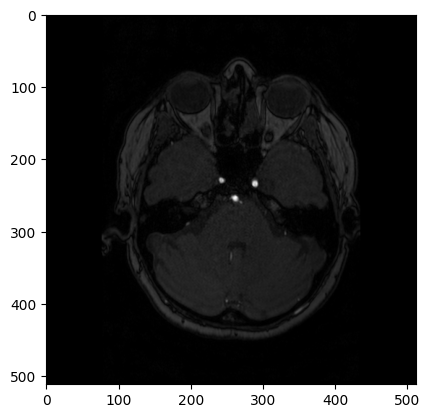

			Image: ('1.3.6.1.4.1.14519.5.2.1.1188.4001.276348900784204133497254433121', '35', 'MR')
Received image:  1.3.6.1.4.1.14519.5.2.1.1188.4001.276348900784204133497254433121


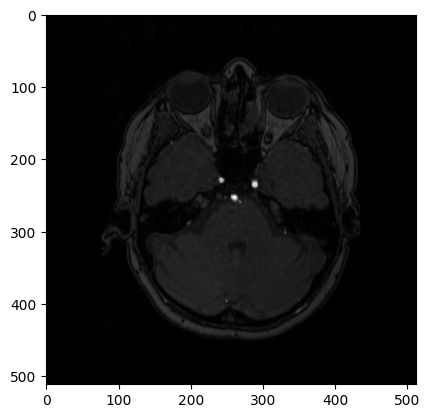

			Image: ('1.3.6.1.4.1.14519.5.2.1.1188.4001.270918844824382877945674902604', '36', 'MR')
Received image:  1.3.6.1.4.1.14519.5.2.1.1188.4001.270918844824382877945674902604


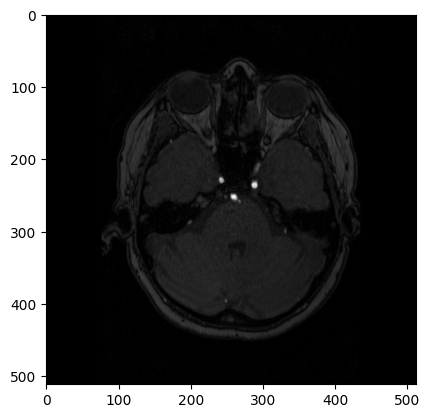

Patient: ('98.12.21', '')
	Study: ('1.2.156.14702.1.1000.16.0.20200311113603875', '')
		Series: ('1.2.156.14702.1.1000.16.1.20200311114023234000110001', 'CT', '10001')
			Image: ('1.3.6.1.4.1.9590.100.1.2.115953616711467210729334842220569228774', '1', 'CT')
Received image:  1.3.6.1.4.1.9590.100.1.2.115953616711467210729334842220569228774


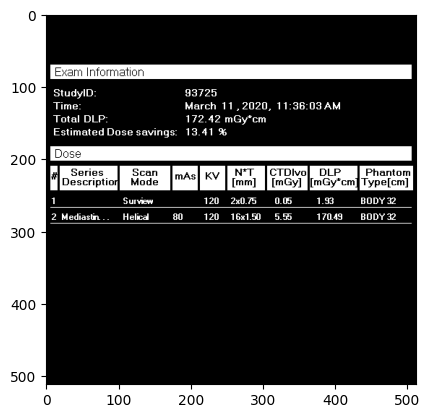

		Series: ('1.2.156.14702.1.1000.16.1.2020031111365295300020004', 'CT', '5')
			Image: ('1.3.6.1.4.1.9590.100.1.2.62174339213775815627839248674285430481', '173', 'CT')
Received image:  1.3.6.1.4.1.9590.100.1.2.62174339213775815627839248674285430481


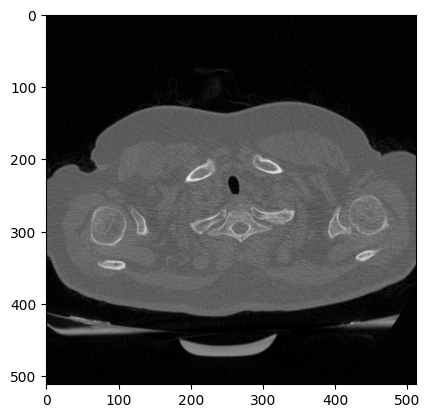

			Image: ('1.3.6.1.4.1.9590.100.1.2.179399156311232526728729586053333968756', '172', 'CT')
Received image:  1.3.6.1.4.1.9590.100.1.2.179399156311232526728729586053333968756


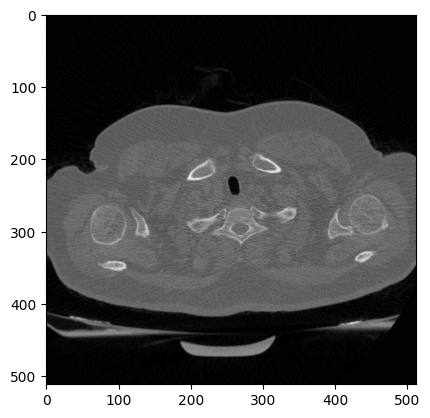

In [9]:
for pat in find_patients():
    print("Patient:", pat)
    for study in find_studies(pat[0]):
        print("\tStudy:", study)
        for series in find_series(study[0]):
            print("\t\tSeries:", series)
            for image in find_images(study[0], series[0]):
                print("\t\t\tImage:", image)
                status = get_image(study[0], series[0], image[0])
                if status:
                    print("Error:", status)
